Import

In [2]:
import torch

import pandas as pd
import numpy as np

from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action = 'ignore')

/Users/dataly/opt/anaconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Load

In [3]:
train_df = pd.read_csv('./data/train.csv')

val_df = pd.read_csv('./data/val.csv')

Validation set 사기 거래 비율

In [4]:
val_normal, val_fraud = val_df['Class'].value_counts()

val_contamination = val_fraud / val_normal

val_contamination

0.0010551491277433877

In [5]:
train_x = train_df.drop(columns = ['ID'])
train_x

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113837,-12.516732,10.187818,-8.476671,-2.510473,-4.586669,-1.394465,-3.632516,5.498583,4.893089,8.655320,...,-0.944759,-1.565026,0.890675,-1.253276,1.786717,0.320763,2.090712,1.232864,-0.169496,1.034857
113838,1.884849,-0.143540,-0.999943,1.506772,-0.035300,-0.613638,0.190241,-0.249058,0.666458,0.120908,...,0.144008,0.634646,-0.042114,-0.053206,0.316403,-0.461441,0.018265,-0.041068,0.530986,1.034881
113839,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,...,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,-0.230699,1.034904
113840,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,...,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,-0.269825,1.034939


Model define, Model Fit

In [6]:
model = EllipticEnvelope(support_fraction= 0.994, contamination=val_contamination, random_state= 25)
model.fit(train_x)

EllipticEnvelope(contamination=0.0010551491277433877, random_state=25,
                 support_fraction=0.994)

In [7]:
def get_pred_label(model, x, k):
    prob = model.score_samples(x)
    prob = torch.tensor(prob, dtype = torch.float)
    topk_indices = torch.topk(prob, k = k, largest = False).indices
    
    pred = torch.zeros(len(x), dtype = torch.long)
    pred[topk_indices] = 1
    return pred.tolist(), prob.tolist()

val_x = val_df.drop(columns = ['ID', 'Class'])
val_y = val_df['Class']

val_pred, val_prob = get_pred_label(model, val_x, 29)
val_score = f1_score(val_y, val_pred, average = 'macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))
tn, fp, fn, tp = confusion_matrix(val_y, val_pred).ravel()
print('tp:', tp, ',fp:', fp, ',tn : ', tn, ', fn :',fn)

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462

tp: 25 ,fp: 4 ,tn :  28428 , fn : 5


Inference

In [8]:
test_df = pd.read_csv('./data/test.csv')
test_df

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,AAAA0x1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,AAAA0x2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,AAAA0x5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,AAAA0x7,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,AAAA0xc,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0x4587f,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,0x45880,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,0x45884,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,0x45885,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


In [9]:
test_x = test_df.drop(columns = ['ID'])
test_x

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142498,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,...,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0.028645,1.034904
142499,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,...,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0.810312,1.034916
142500,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0.038986,1.034963
142501,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0.641096,1.034975


Visualization

array([[<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>,
        <AxesSubplot:title={'center':'V5'}>],
       [<AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>,
        <AxesSubplot:title={'center':'V10'}>],
       [<AxesSubplot:title={'center':'V11'}>,
        <AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>,
        <AxesSubplot:title={'center':'V15'}>],
       [<AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>,
        <AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V20'}>],
       [<AxesSubplot:title={'center':'V21'}>,
        <AxesSubplot:title={'center':'V

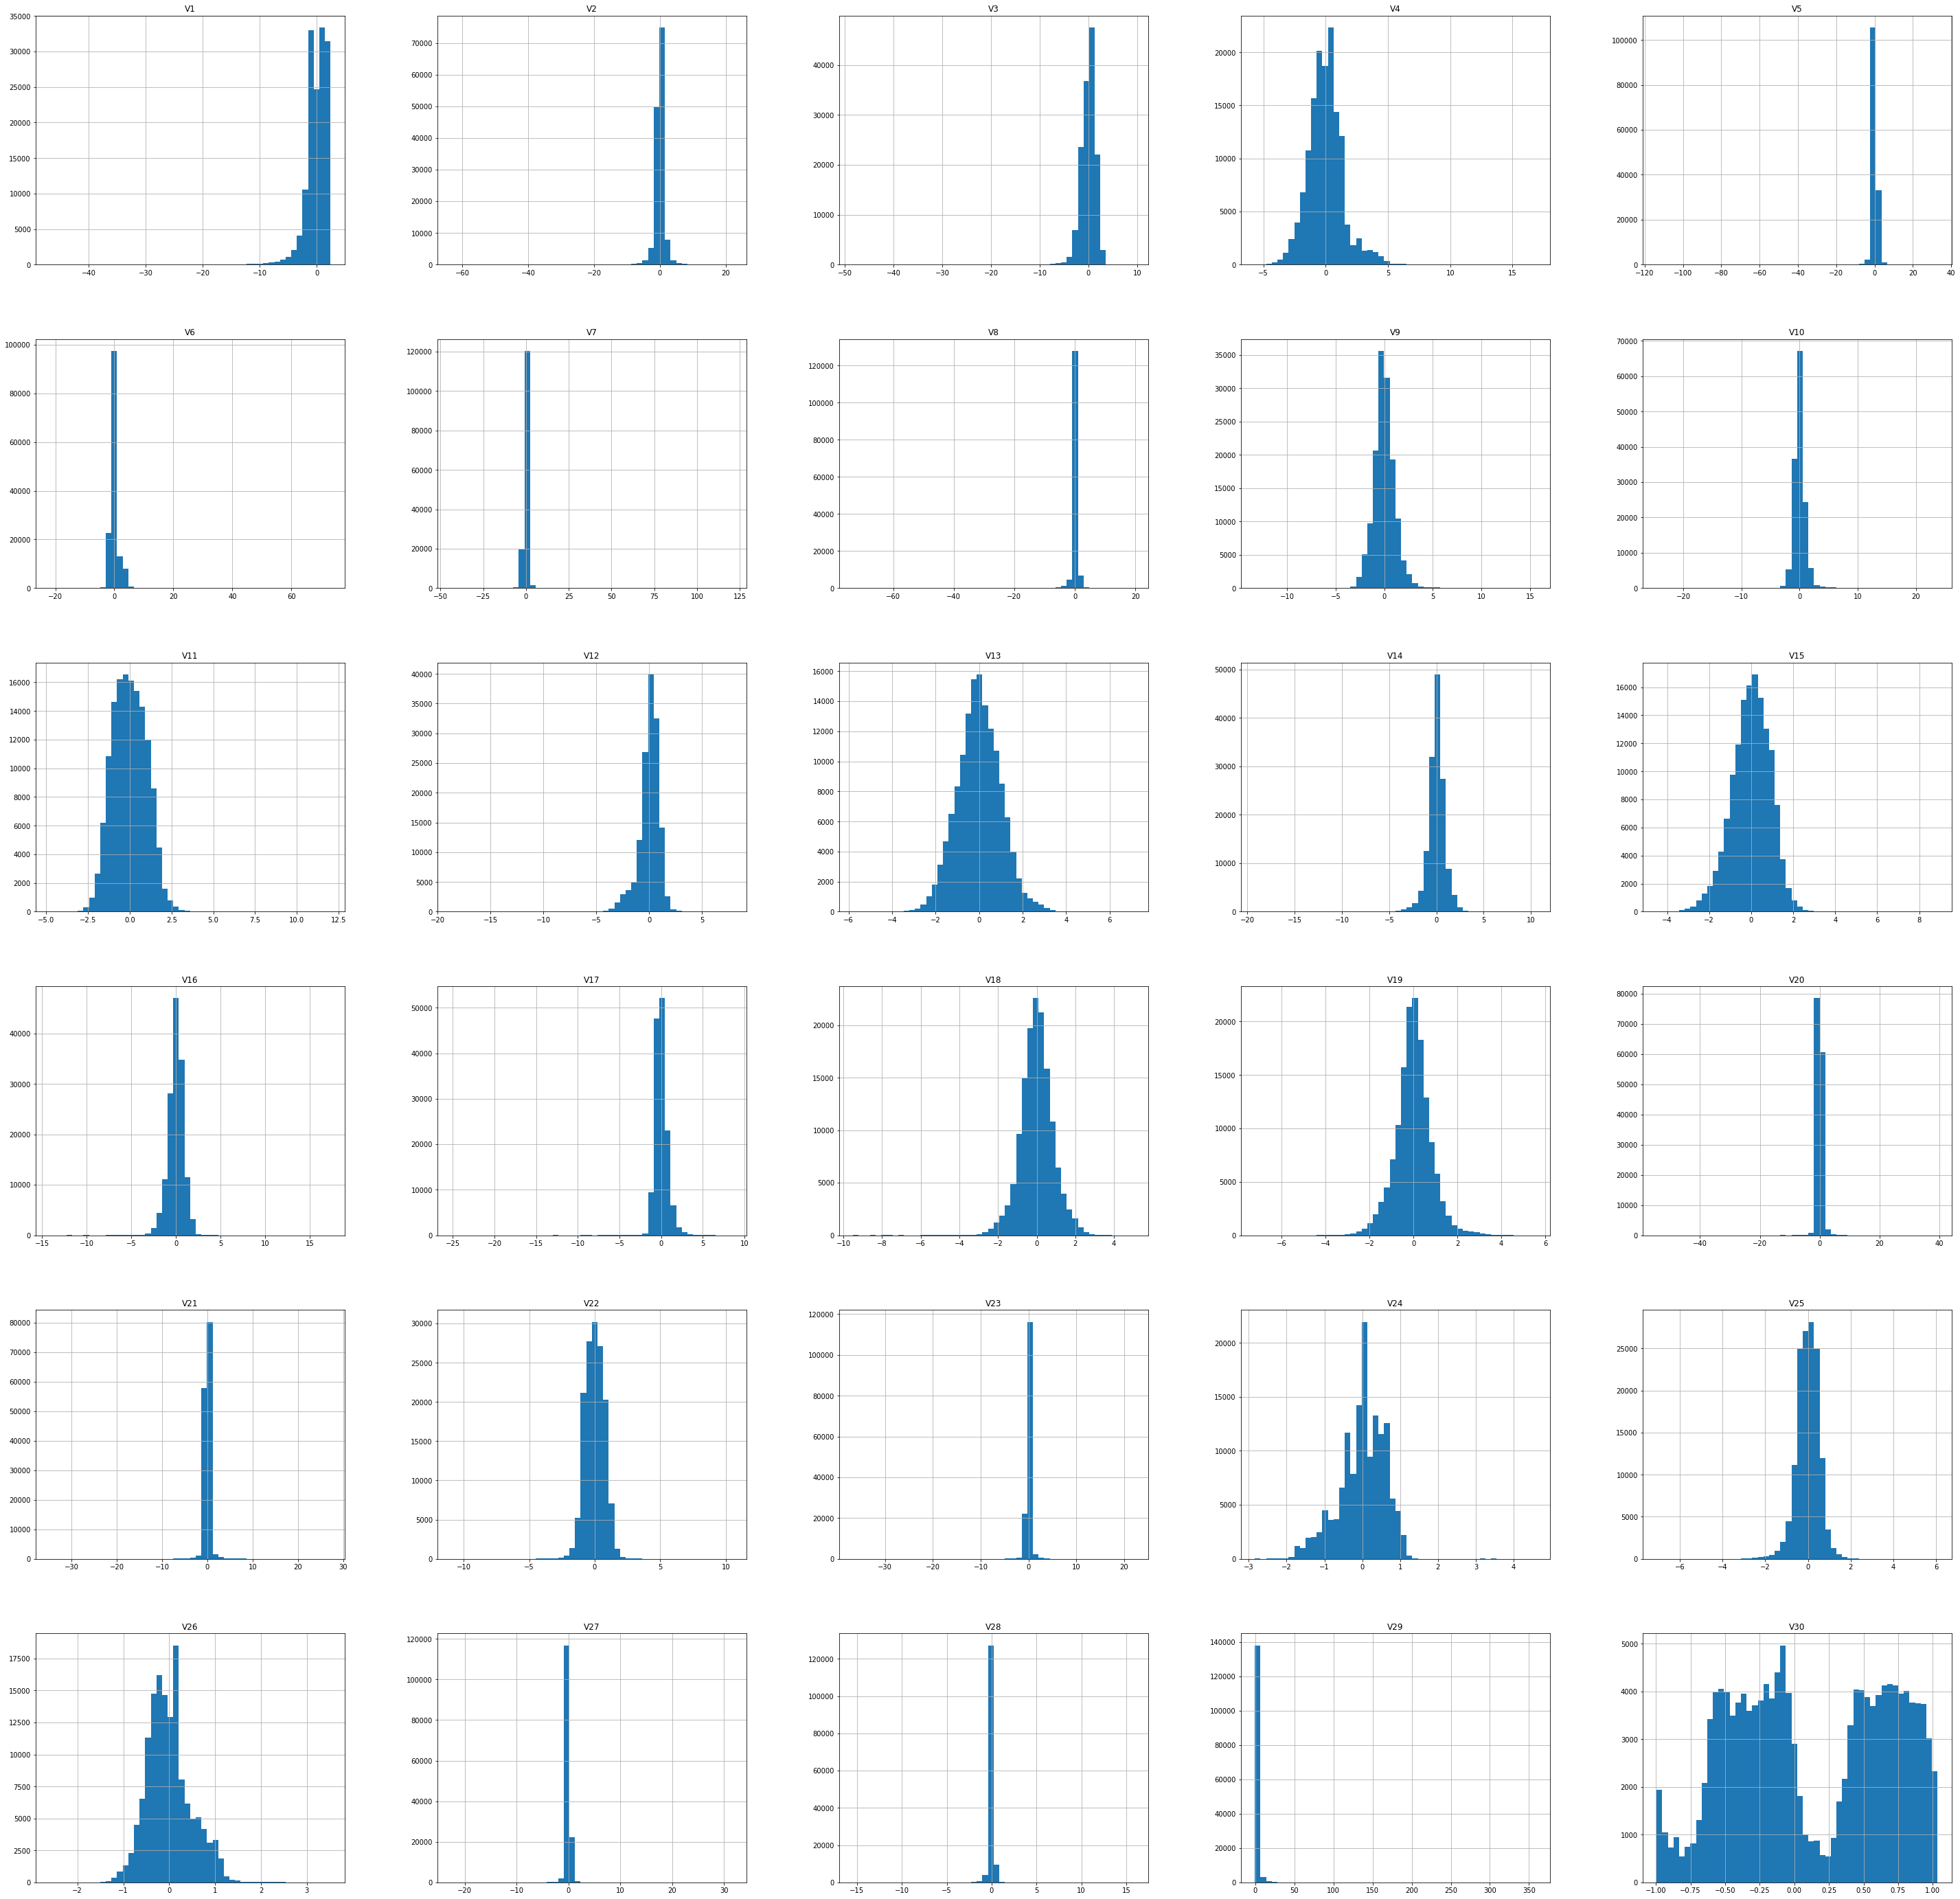

In [16]:
test_x.hist(bins=50, figsize=(50,50))

array([[<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>,
        <AxesSubplot:title={'center':'V5'}>],
       [<AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>,
        <AxesSubplot:title={'center':'V10'}>],
       [<AxesSubplot:title={'center':'V11'}>,
        <AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>,
        <AxesSubplot:title={'center':'V15'}>],
       [<AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>,
        <AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V20'}>],
       [<AxesSubplot:title={'center':'V21'}>,
        <AxesSubplot:title={'center':'V

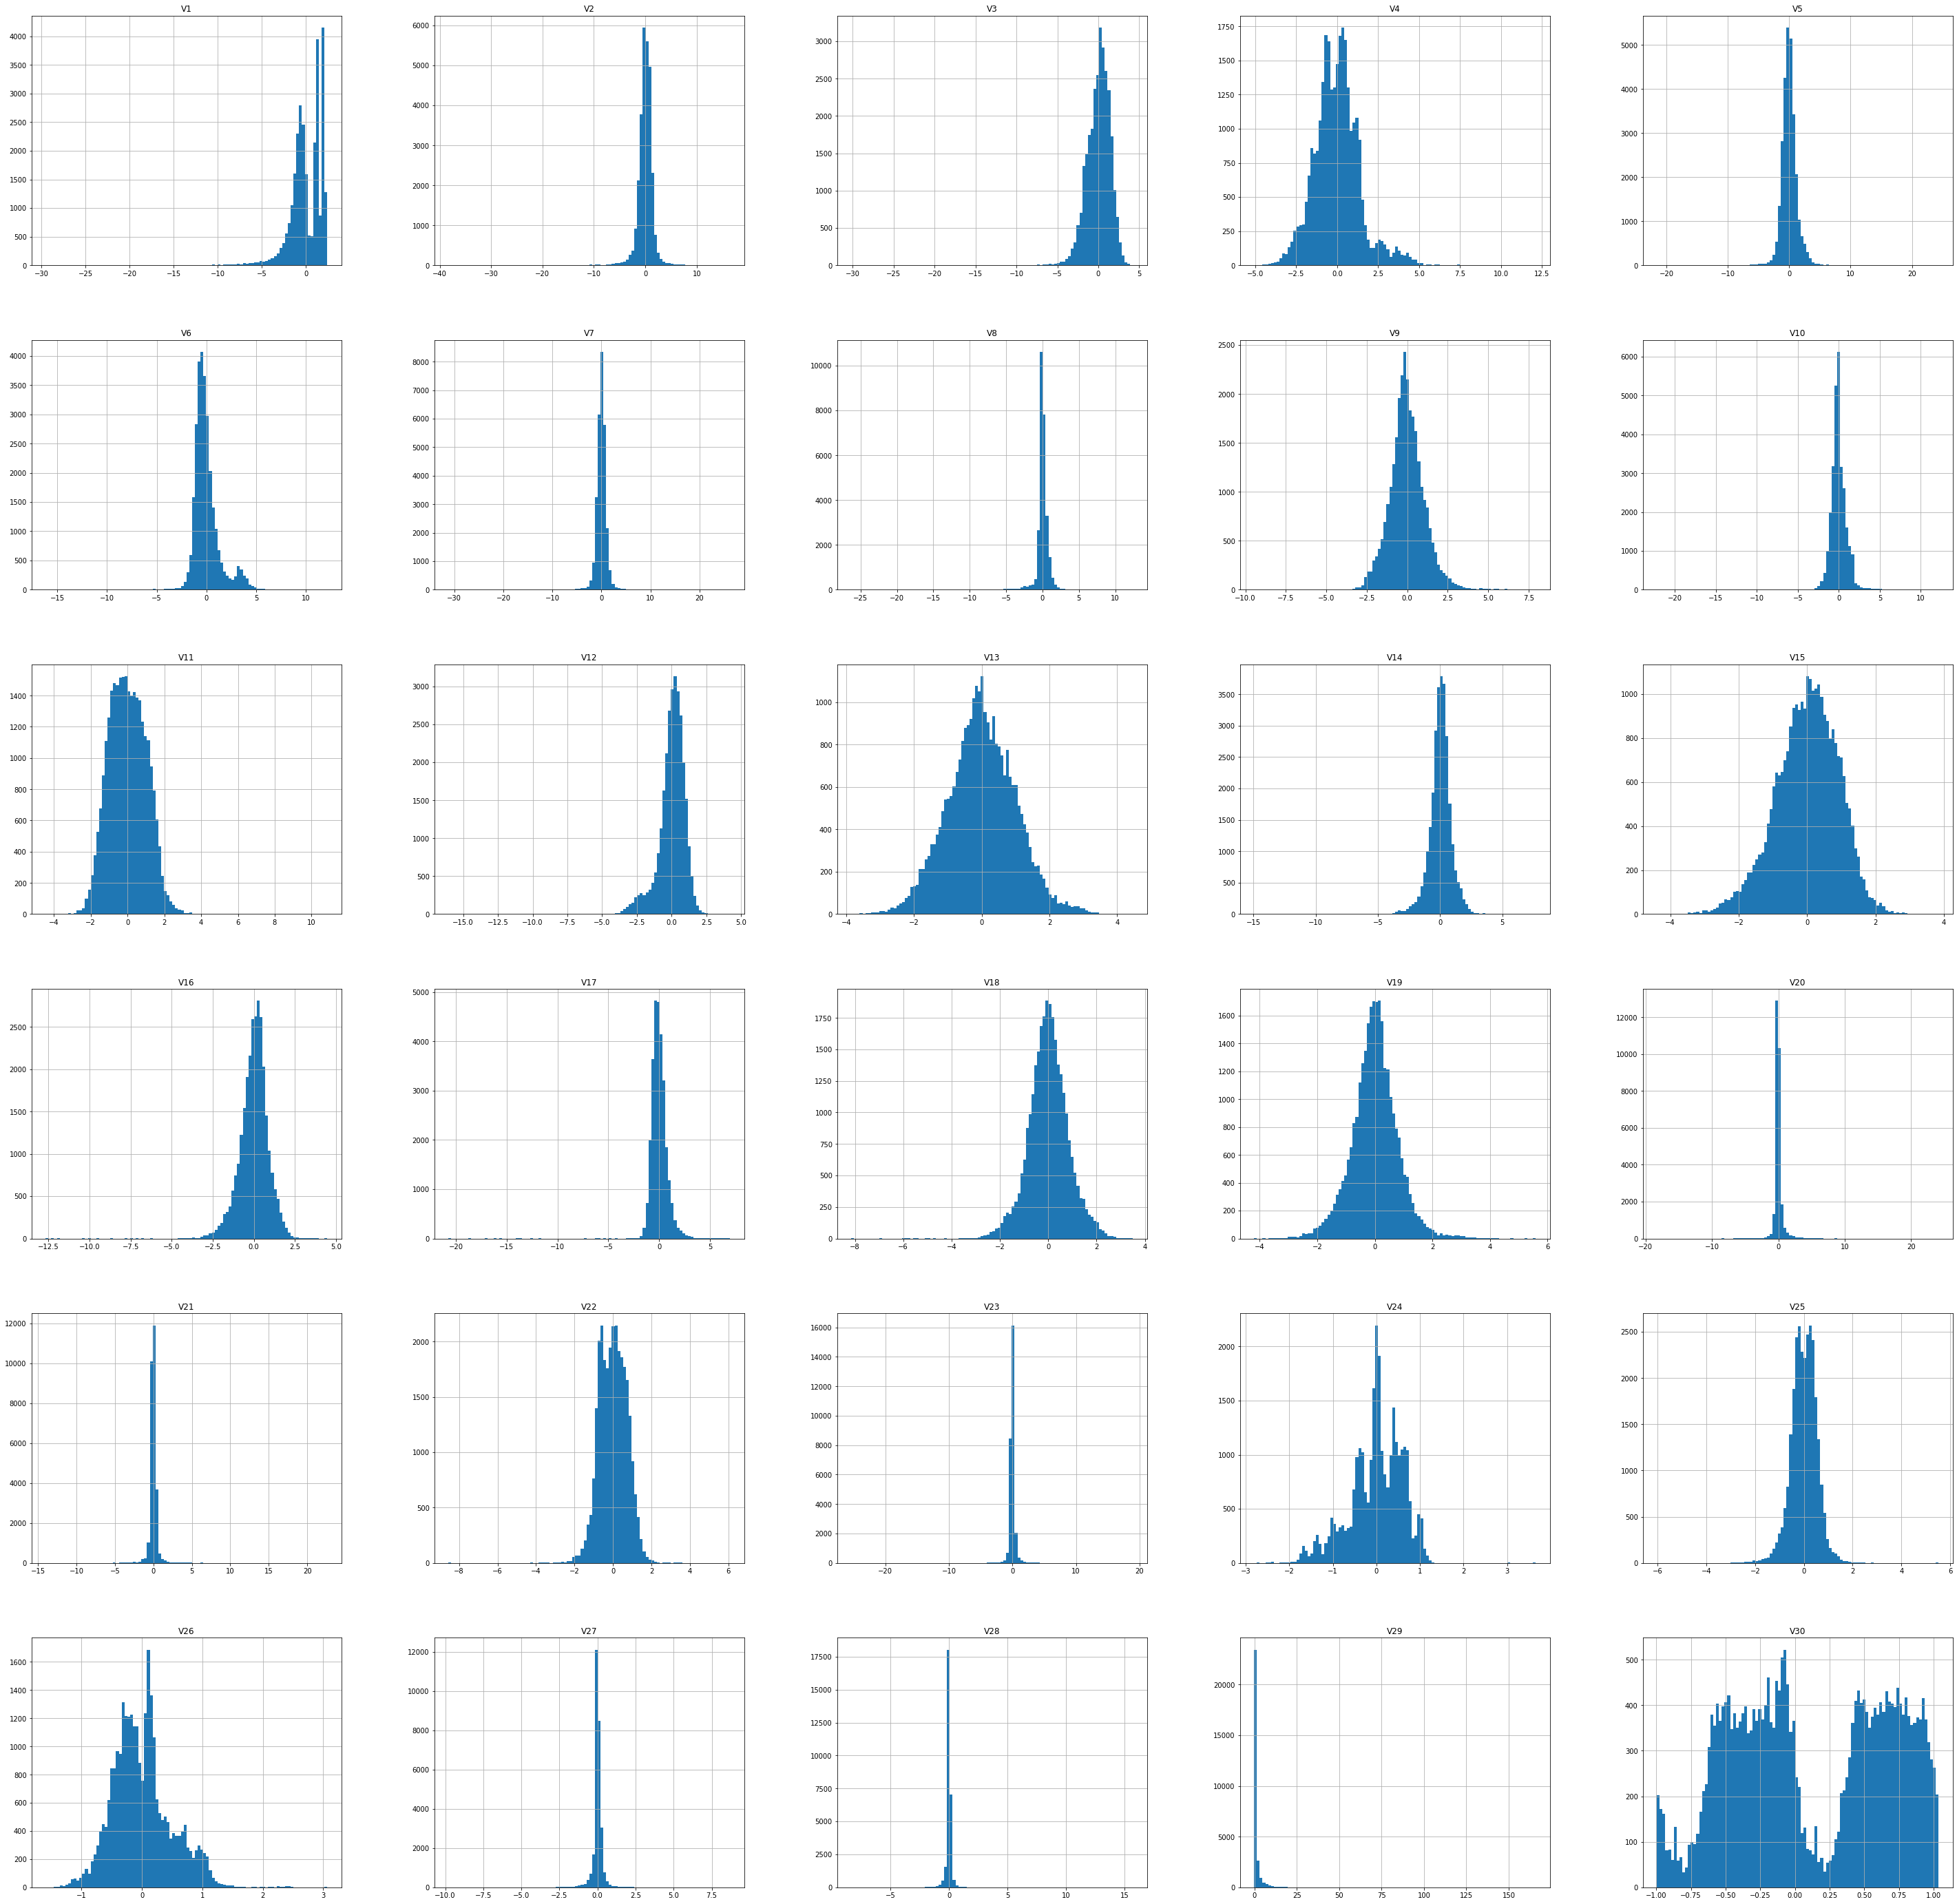

In [17]:
val_x.hist(bins = 100, figsize=(50,50))

In [11]:
test_pred, _ = get_pred_label(model, test_x, 318)
print('n_fraud : ', sum(test_pred))

n_fraud :  318


Submission

In [12]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [13]:
submit['Class'] = test_pred
submit.to_csv('./EllipticEnvelope.csv', index = False)

In [14]:
pd.read_csv('./EllipticEnvelope.csv')['Class'].sum()

318